## Compile the redox potentials
We want to see what the energy differences for different methods are and compare the runtimes

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from scipy.stats import linregress, siegelslopes
from ase.db import connect
import pandas as pd
import numpy as np

## Load the Database into Pandas
Get the energies for each system for each CP2K setting

In [2]:
example_molecules = pd.read_csv('../data/example_molecules.csv')

In [3]:
mol_props = example_molecules.set_index('inchi_key').to_dict('index')

In [4]:
data = []
for psolver in ['mt', 'wavelet', 'mt-all']:
    with connect(f'{psolver}/data.db') as db:
        for row in db.select(''):
            record = row.key_value_pairs.copy()
            record['basis_set'] = record['basis_set'].upper()
            record['n_electrons'] = mol_props[record['inchi_key']]['n_electrons']
            record['energy'] = row.energy
            record['solver'] = psolver
            record['gpu'] = row.key_value_pairs.get('gpu', True)
            data.append(record)
data = pd.DataFrame(data)
print(f'Loaded {len(data)} computations')

Loaded 105 computations


## Compute the redox potentials
Get the energy differences between different stats

In [5]:
method_keys = ['solver', 'basis_set', 'xc', 'cutoff', 'buffer', 'gpu']
records = []
for lid, (level, subset) in enumerate(data.groupby(method_keys)):
    method_desc = dict(zip(method_keys, level))
    
    # Match states
    neutrals = subset.query('state=="neutral"')
    for state in ['oxidized', 'reduced']:
        redoxed = subset.query(f'state=="{state}"')
        merged = redoxed.merge(neutrals, on=('inchi_key', 'xc', 'cutoff'))
        
        # Create a record for each
        for _, row in merged.iterrows():
            record = {}
            record['inchi_key'] = row['inchi_key']
            record['state'] = state
            record['potential'] = row['energy_x'] - row['energy_y']
            record['runtime'] = row['runtime_x'] + row['runtime_y']
            record['level_id'] = lid
            record['n_electrons'] = row['n_electrons_x']
            record.update(method_desc)
            records.append(record)
records = pd.DataFrame(records)

## Compare Integrators
Determine whether wavelets or MT are a better choice

In [6]:
mt_params = {'solver': 'mt', 'xc': 'BLYP', 'cutoff': 700, 'basis_set': 'DZVP-MOLOPT-GTH', 'gpu': True}
wavelet_params = {'solver': 'wavelet', 'xc': 'BLYP', 'cutoff': 700, 'basis_set': 'DZVP-MOLOPT-GTH', 'gpu': True}

In [7]:
mt_records = records.copy()
for k, v in mt_params.items():
    mt_records = mt_records[mt_records[k] == v]
assert len(mt_records.level_id.value_counts()) == 1
print(f'Reduced to {len(mt_records)} results for MT')
mt_records.head(2)

Reduced to 9 results for MT


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer,gpu
2,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.328979,719.730224,1,6,mt,DZVP-MOLOPT-GTH,BLYP,700,7.5,True
3,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,9.645187,3421.286608,1,24,mt,DZVP-MOLOPT-GTH,BLYP,700,7.5,True


In [8]:
wavelet_records = records.copy()
for k, v in wavelet_params.items():
    wavelet_records = wavelet_records[wavelet_records[k] == v]
assert len(wavelet_records.level_id.value_counts()) == 1
print(f'Reduced to {len(wavelet_records)} results for wavelet')
wavelet_records.head(2)

Reduced to 12 results for wavelet


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer,gpu
55,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.329008,353.397923,8,6,wavelet,DZVP-MOLOPT-GTH,BLYP,700,5.0,True
56,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,9.645519,2661.334518,8,24,wavelet,DZVP-MOLOPT-GTH,BLYP,700,5.0,True


Compare results

In [9]:
merged = mt_records.merge(wavelet_records, on=('inchi_key', 'state', 'basis_set', 'xc', 'n_electrons'))
n_basis = len(mt_records.basis_set.value_counts())

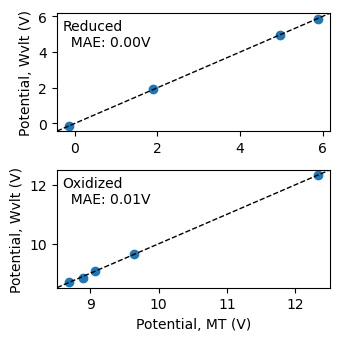

In [10]:
fig, axs = plt.subplots(2, n_basis, figsize=(3.5, 3.5))

for ax, (gid, group) in zip(axs[:, None].T, merged.groupby('basis_set')):
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = group.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
    
        a.set_ylabel('Potential, Wvlt (V)')
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, MT (V)')
    
fig.tight_layout()

They are identical

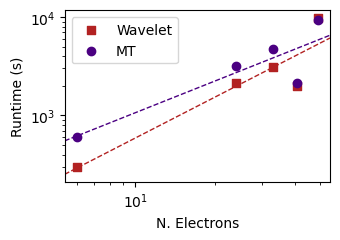

In [11]:
fig, axs = plt.subplots(1, n_basis, sharey=True, figsize=(3.5, 2.5))

for ax, (basis, group) in zip([axs], merged.groupby('basis_set')):   
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='Wavelet')
    wt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='MT')
    mt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(wt_linreg.intercept + wt_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(mt_linreg.intercept + mt_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_ylabel('Runtime (s)')
    ax.set_xlabel('N. Electrons')
    
fig.tight_layout()

Wavelet seems to be decently faster on GPUs for small molecules. It becomes irrelevant at larger sizes.

## Compare CPU to GPU Implementation
Get the MT, but with a GPU-accelerated version.

In [12]:
gpu_params = wavelet_params.copy()
gpu_params.pop('gpu')
gpu_params

{'solver': 'wavelet',
 'xc': 'BLYP',
 'cutoff': 700,
 'basis_set': 'DZVP-MOLOPT-GTH'}

In [13]:
all_records = data.copy()
for k, v in gpu_params.items():
    all_records = all_records[all_records[k] == v]
print(f'Reduced to {len(all_records)} results for GPU vs CPU comparison')
all_records.head(2)

Reduced to 25 results for GPU vs CPU comparison


,inchi_key,state,runtime,hostname,basis_set,cutoff,buffer,xc,gpu,n_electrons,energy,solver,rel_cutoff,basis_set_file
18,VNWKTOKETHGBQD-UHFFFAOYSA-N,neutral,64.706552,bettik-linux,DZVP-MOLOPT-GTH,700,5.0,BLYP,True,6,-219.160490,wavelet,NaN,NaN
19,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,288.691371,bettik-linux,DZVP-MOLOPT-GTH,700,5.0,BLYP,True,6,-206.831482,wavelet,NaN,NaN


In [14]:
merged = all_records.query('not gpu').merge(all_records.query('gpu'), on=('inchi_key', 'state', 'basis_set', 'xc', 'n_electrons'))
merged['speedup'] = merged['runtime_x'] / merged['runtime_y']

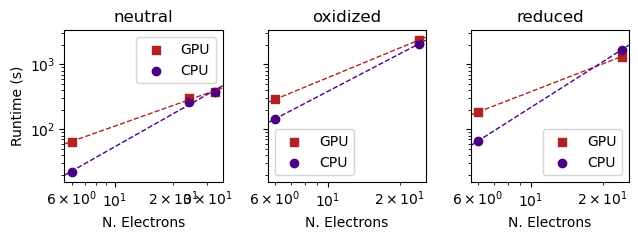

In [15]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(6.5, 2.5))

for ax, (state, group) in zip(axs, merged.groupby('state')):   
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='GPU')
    wt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_y']))
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CPU')
    mt_linreg = linregress(np.log(subset.index), np.log(subset['runtime_x']))
    
    # Set up the scale
    ax.set_title(state)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.legend()
    
    # Plot the linear regressions
    ax.set_xlim(ax.get_xlim())
    ax.plot(ax.get_xlim(), np.exp(wt_linreg.intercept + wt_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(mt_linreg.intercept + mt_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
axs[0].set_ylabel('Runtime (s)')
    
fig.tight_layout()

In [16]:
merged.speedup.describe()

count    7.000000
mean     0.744125
std      0.350911
min      0.345755
25%      0.429626
50%      0.870818
75%      0.929182
max      1.274684
Name: speedup, dtype: float64

In [17]:
merged.groupby('state')['speedup'].describe()

,count,mean,std,min,25%,50%,75%,max
state,,,,,,,,
neutral,3.0,0.733760,0.340814,0.345755,0.608286,0.870818,0.927763,0.984708
oxidized,2.0,0.687189,0.263704,0.500722,0.593956,0.687189,0.780423,0.873656
reduced,2.0,0.816607,0.647819,0.358530,0.587569,0.816607,1.045646,1.274684


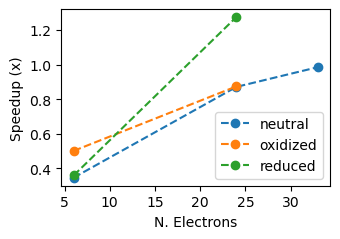

In [18]:
fig, ax = plt.subplots(1, sharey=True, figsize=(3.5, 2.5))

for state, group in merged.groupby('state'):
    subset = group.groupby('n_electrons').mean()
        
    # Plot the values
    ax.plot(subset.index, subset['speedup'], '--o', label=state)
    
# Set up the scale
ax.set_ylabel('Speedup (x)')
ax.set_xlabel('N. Electrons')
ax.legend()
    
fig.tight_layout()

The speedup of using a GPU only becomes possible with larger systems

## Compare to NWChem
Make sure we are close to our baseline values

### Pseudopotential CP2K
Get the psuedopotential results (GPW)

In [19]:
gpw_params = {'solver': 'mt', 'basis_set': 'DZVP-MOLOPT-GTH'}

In [20]:
gpw_records = records.copy()
gpw_params.pop('basis_set', None)
for k, v in gpw_params.items():
    gpw_records = gpw_records[gpw_records[k] == v]
print(f'Reduced to {len(gpw_records)} results for MT-GPU')
gpw_records.head(2)

Reduced to 11 results for MT-GPU


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer,gpu
0,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,12.540889,743.397312,0,6,mt,DZVP-MOLOPT-GTH,B3LYP,700,7.5,True
1,VNWKTOKETHGBQD-UHFFFAOYSA-N,reduced,6.011493,485.636509,0,6,mt,DZVP-MOLOPT-GTH,B3LYP,700,7.5,True


In [21]:
chosen = gpw_records
print(f'Ran CP2K for {len(chosen.inchi_key.value_counts())} molecules')

Ran CP2K for 5 molecules


In [22]:
nwchem_results = pd.read_csv('../nwchem/nwchem-redox-potentials.csv').query('basis_set=="cc-pvdz"')
print(f'Ran NWChem for {len(nwchem_results.inchi_key.value_counts())} molecules')

Ran NWChem for 12 molecules


Compare to NWChem for different XC functionals

In [23]:
matched_xc = [('BLYP', 'B3LYP'), ('B3LYP', 'B3LYP')]

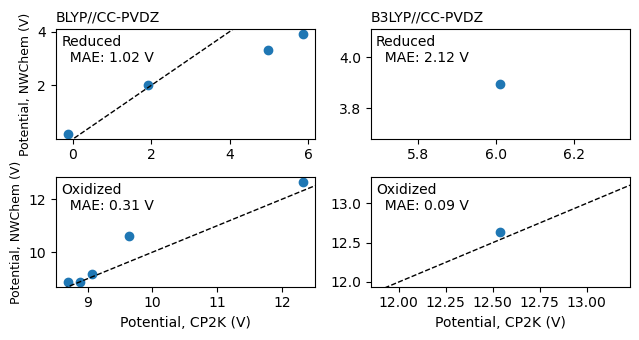

In [24]:
fig, axs = plt.subplots(2, len(matched_xc), figsize=(6.5, 3.5))

for ax, (cp2k_xc, nwc_xc) in zip(axs[:, :].T, matched_xc):
    ax[0].set_title(f'{cp2k_xc}//CC-PVDZ', fontsize=10, loc='left')
    nwchem_subset = nwchem_results.query(f'xc=="{nwc_xc}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'xc=="{cp2k_xc}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = merged.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f} V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, CP2K (V)')
    
for ax in axs[:, 0]:
    ax.set_ylabel('Potential, NWChem (V)', fontsize=9)
    
fig.tight_layout()

/home/lward/miniconda3/envs/qcgpu/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/lward/miniconda3/envs/qcgpu/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


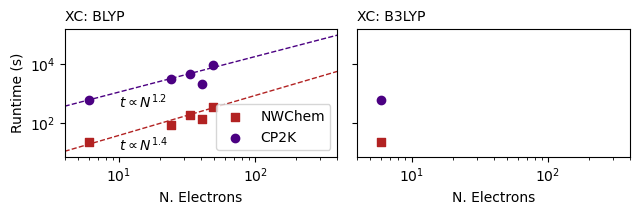

In [25]:
fig, axs = plt.subplots(1, len(matched_xc), sharey=True, sharex=True, figsize=(6.5, 2.25))

for ax, (cp2k_xc, nwc_xc) in zip(axs, matched_xc):
    nwchem_subset = nwchem_results.query(f'xc=="{nwc_xc}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'xc=="{cp2k_xc}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    subset = merged.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='NWChem')
    nwc_linreg = siegelslopes(np.log(subset['runtime_y']), np.log(subset.index))
    ax.text(10, np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{nwc_linreg.slope:.1f}}}$', va='top')
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CP2K')
    cpk_linreg = siegelslopes(np.log(subset['runtime_x']), np.log(subset.index))
    ax.text(10, np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{cpk_linreg.slope:.1f}}}$', va='top')
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Plot the linear regressions
    ax.set_xlim([4, 400])
    ax.plot(ax.get_xlim(), np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
    ax.set_title(f'XC: {cp2k_xc}', fontsize=10, loc='left')

axs[0].set_ylabel('Runtime (s)')
axs[0].legend()
fig.tight_layout()

### All-electron CP2K
Get the all-electron results (GAPW)

In [26]:
gapw_params = {'solver': 'mt-all', 'xc': 'HYB_GGA_XC_B3LYP'}

In [27]:
gapw_records = records.copy()
gapw_params.pop('basis_set', None)
for k, v in gapw_params.items():
    gapw_records = gapw_records[gapw_records[k] == v]
print(f'Reduced to {len(gapw_records)} results for All electron')
gapw_records.head(2)

Reduced to 38 results for All electron


,inchi_key,state,potential,runtime,level_id,n_electrons,solver,basis_set,xc,cutoff,buffer,gpu
11,VNWKTOKETHGBQD-UHFFFAOYSA-N,oxidized,10.732057,293.281157,2,6,mt-all,DEF2-SVP,HYB_GGA_XC_B3LYP,400,7.0,True
12,IJDNQMDRQITEOD-UHFFFAOYSA-N,oxidized,8.259383,1674.876149,2,24,mt-all,DEF2-SVP,HYB_GGA_XC_B3LYP,400,7.0,True


In [28]:
chosen = gapw_records
print(f'Ran CP2K for {len(chosen.inchi_key.value_counts())} molecules')

Ran CP2K for 9 molecules


In [29]:
nwchem_results = pd.read_csv('../nwchem/nwchem-redox-potentials.csv')
print(f'Ran NWChem for {len(nwchem_results.inchi_key.value_counts())} molecules')

Ran NWChem for 12 molecules


Compare to NWChem

In [30]:
matched_basis = [('DZVP-ALL', 'cc-pvdz'), ('DEF2-SVP', 'def2-svp'), ('DEF2-TZVPD', 'def2-tzvpd')]

In [31]:
nwchem_results.basis_set.value_counts()

aug-cc-pvdz    42
6-31g**        24
cc-pvdz        24
def2-svp       14
def2-tzvpd      5
Name: basis_set, dtype: int64

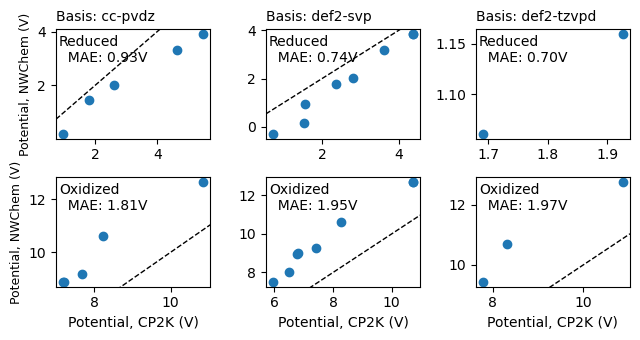

In [32]:
fig, axs = plt.subplots(2, len(matched_basis), figsize=(6.5, 3.5))

for ax, (cp2k_basis, nwc_basis) in zip(axs[:, :].T, matched_basis):
    ax[0].set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    for a, s in zip(ax, ['reduced', 'oxidized']): 
        subset = merged.query(f'state=="{s}"')
        a.scatter(subset['potential_x'], subset['potential_y'], label=s)
        mae = (subset['potential_x'] - subset['potential_y']).abs().mean()
    
        a.set_xlim(a.get_xlim())
        a.set_ylim(a.get_ylim())
    
        a.plot(a.get_xlim(), a.get_xlim(), 'k--', lw=1)
        
        a.text(0.02, 0.95, s.capitalize() + f'\n  MAE: {mae:.2f}V', ha='left', va='top', transform=a.transAxes)
    
    ax[-1].set_xlabel('Potential, CP2K (V)')
    
for ax in axs[:, 0]:
    ax.set_ylabel('Potential, NWChem (V)', fontsize=9)
    
fig.tight_layout()

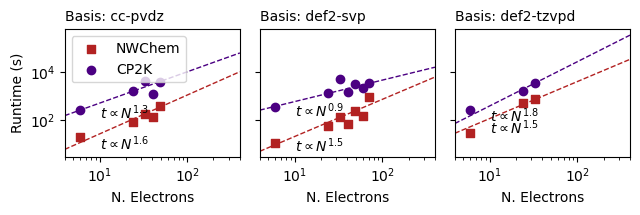

In [33]:
fig, axs = plt.subplots(1, len(matched_basis), sharey=True, sharex=True, figsize=(6.5, 2.25))

for ax, (cp2k_basis, nwc_basis) in zip(axs, matched_basis):
    nwchem_subset = nwchem_results.query(f'basis_set=="{nwc_basis}"').sort_values('runtime', ascending=True).drop_duplicates(('inchi_key', 'state'), keep='first')
    merged = chosen.query(f'basis_set=="{cp2k_basis}"').merge(nwchem_subset, on=('inchi_key', 'state'))
    
    subset = merged.groupby('n_electrons').mean()
        
    # Plot the values
    ax.scatter(subset.index, subset['runtime_y'], color='firebrick', marker='s', label='NWChem')
    nwc_linreg = siegelslopes(np.log(subset['runtime_y']), np.log(subset.index))
    ax.text(10, np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{nwc_linreg.slope:.1f}}}$', va='top')
    
    ax.scatter(subset.index, subset['runtime_x'], color='indigo', marker='o', label='CP2K')
    cpk_linreg = siegelslopes(np.log(subset['runtime_x']), np.log(subset.index))
    ax.text(10, np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(10)), 
            f'$t \propto N^{{{cpk_linreg.slope:.1f}}}$', va='top')
    
    # Set up the scale
    ax.set_yscale('log')
    ax.set_xscale('log')
    
    # Plot the linear regressions
    ax.set_xlim([4, 400])
    ax.plot(ax.get_xlim(), np.exp(nwc_linreg.intercept + nwc_linreg.slope * np.log(ax.get_xlim())), 
            '--', lw=1, color='firebrick')
    ax.plot(ax.get_xlim(), np.exp(cpk_linreg.intercept + cpk_linreg.slope * np.log(ax.get_xlim())),
            '--', lw=1, color='indigo')
    
    ax.set_xlabel('N. Electrons')
    ax.set_title(f'Basis: {nwc_basis}', fontsize=10, loc='left')

axs[0].set_ylabel('Runtime (s)')
axs[0].legend()
fig.tight_layout()